# Problem 002: Even Fibonacci Numbers
Each new term in the Fibonacci sequence is generated by adding the previous two terms.\
By starting with 1 and 2, the first 10 terms will be:

$$1, 2, 3, 5, 8, 13, 21, 34, 55, 89, \ldots$$

**By considering the terms in the Fibonacci sequence whose values do not
exceed four million, find the sum of the even-valued terms.**

## Designing the Solution
In order to solve this problem, we need to find all values of the [Fibonacci Sequence](https://en.wikipedia.org/wiki/Fibonacci_sequence) up to the given limit, then filter out all even numbers and finally add them up.

The Fibonacci numbers can be defined by this [recurrence relation](https://en.wikipedia.org/wiki/Recurrence_relation):


$$\begin{align*}
F_0 &= 0 \\
F_1 &= 1 \\
F_n &= F_{n-1} + F_{n-2}, \quad \text{for} \ n > 1.
\end{align*}$$

Formulae given by a *recurrence realation* can easily be implemented with a recursive defined procedure; in our case this could look like so:

In [1]:
fib(n) = n < 2 ? n : fib(n-1) + fib(n-2)

fib (generic function with 1 method)

In [2]:
using BenchmarkTools

@btime fib(40)

  400.838 ms (0 allocations: 0 bytes)


102334155

While corrrect, this implementation raises a number of problems:

* first and foremost, it is very slow. The number of computations will grow very fast with a growing input size; to be more precise, combining two mutual recursive calls in one expression will lead to an *exponential growth*, $\Theta(2^n)$.
* Not representing a *tail-recursive* call, the program has to add a new frame onto the program stack for every call, leading to an exponential *space complexity* as well.

* Finally, we would have to call that procedure for every natural number until the result exceeds the given limit in order to solve the original problem.

### Recursive Solution with Memoization
To overcome the limitations of a naive recursive implementation, we will use [Memoization](https://en.wikipedia.org/wiki/Memoization) for our solution.\
*Memoization* is an algorithmic technique, in which all intermediate values are stored in a temporary cache.
With that we need only one recursive call for computing every next value; the recursive call itself doesn't change from the naive implementation.\
For the cache we use a dictionary of type `Dict{BigInt, BigInt}`, which allows storing of very large `Integer` values and guarantees efficient lookup of already computed values.

In [3]:
global fibCache = Dict{BigInt, BigInt}(0 => 0, 1 => 1)

function fibMemo(n::Integer)
    global fibCache
    if haskey(fibCache, n)
        fibCache[n]
    else
        fibCache[n] = fibMemo(n-1) + fibMemo(n-2)
    end
end

fibMemo (generic function with 1 method)

Notice the the type of the input value `n::Integer`.\
This allows us to call the function with an `Int64` value, which is the standard on a 64-bit machine, as well as storing the computed values in the cache, which expects `BigInt`.
This is possible because `Integer` is the *supertype* of `Int64` as well as of `BigInt`.\
Let's have a short look at the *numerical tower* in julia:

In [4]:
function print_subtypes(T::Type, indent_level = 0)
    println(" " ^ indent_level, T)
    for S in subtypes(T)
        print_subtypes(S, indent_level + 2)
    end
    return nothing
end

print_subtypes(Real)

Real
  AbstractFloat
    BigFloat
    Float16
    Float32
    Float64
  AbstractIrrational
    Irrational
  Integer
    Bool
    Signed
      BigInt
      Int128
      Int16
      Int32
      Int64
      Int8
    Unsigned
      UInt128
      UInt16
      UInt32
      UInt64
      UInt8
  Rational


In [5]:
@btime fibMemo(40)

  34.334 ns (0 allocations: 0 bytes)


102334155

Even for this small input, the naive recursive implementation takes about $10^7$ times longer to finish than the *memoized* version. That's the price of exponential growth!

As a side effect of memoization, we also get a collection of all computed *fibonacci* terms, which we can use for futher processing:

In [6]:
fibCache

Dict{BigInt, BigInt} with 41 entries:
  5  => 5
  16 => 987
  20 => 6765
  35 => 9227465
  12 => 144
  24 => 46368
  28 => 317811
  8  => 21
  17 => 1597
  30 => 832040
  1  => 1
  19 => 4181
  0  => 0
  22 => 17711
  6  => 8
  23 => 28657
  11 => 89
  32 => 2178309
  36 => 14930352
  9  => 34
  31 => 1346269
  37 => 24157817
  14 => 377
  3  => 2
  39 => 63245986
  ⋮  => ⋮

In [7]:
memoSolution(limit) = sum(v -> (v <= limit && iseven(v)) ? v : 0, values(fibCache))

memoSolution (generic function with 1 method)

Evaluating the *Fibonacci Sequence* by hand, we get a result of `44` for the sum of all even terms not exceeding 100; we use this result for testing:

In [8]:
@assert memoSolution(100) == 44

### Iterative Solution
For a iterative solution we use the fact that every next *Fibionacci* number is the sum of its two predecessors.
Instead of receiving just one argument for $F_n$, this new procedure takes 2 arguments (the predecessors of $F_n$), adds them up, and if the result is even, adds it to the accumulated sum.

In [9]:
function iterSolution(limit::Integer)::BigInt
    a = 0
    b = 1
    acc = 0
    while (a + b) <= limit
        next = a + b
        if iseven(next)
            acc += next
        end
        a, b = b, a+b
    end
    acc
end

iterSolution (generic function with 1 method)

In [10]:
@assert iterSolution(100) == 44

In [11]:
for l in rand(1_000:10_000, 100)
    @assert iterSolution(l) == memoSolution(l)
end

### Performance
Let's check how our solutions so far are doing:

In [12]:
@benchmark memoSolution(4_000_000)

BenchmarkTools.Trial: 10000 samples with 10 evaluations.
 Range (min … max):  1.688 μs …   8.890 ms  ┊ GC (min … max):  0.00% … 81.43%
 Time  (median):     1.810 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.012 μs ± 110.716 μs  ┊ GC (mean ± σ):  34.05% ±  1.27%

   ██                                                          
  ▂███▅▄▃▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▃▇█▅▃▂▁▁▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  1.69 μs         Histogram: frequency by time        2.77 μs <

 Memory estimate: 1.80 KiB, allocs estimate: 104.

In [13]:
@benchmark iterSolution(4_000_000)

BenchmarkTools.Trial: 10000 samples with 991 evaluations.
 Range (min … max):  38.144 ns … 108.585 μs  ┊ GC (min … max):  0.00% … 79.35%
 Time  (median):     40.570 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   94.230 ns ±   1.903 μs  ┊ GC (mean ± σ):  34.22% ±  1.74%

   ▅█▇▅                                                         
  ▃█████▄▃▂▂▂▂▂▃▂▂▃▂▂▃▃▃▄▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  38.1 ns         Histogram: frequency by time         69.9 ns <

 Memory estimate: 40 bytes, allocs estimate: 2.

Let's rewrite the iterative solution with a recursive loop:

In [14]:
function iterRecSolution(limit::Integer)::BigInt
    function loop(a, b, acc)
        next = a + b
        if next > limit
            acc
        elseif iseven(next)
            loop(b, next, acc+next)
        else
            loop(b, next, acc)
        end
    end
    loop(0, 1, 0)
end

iterRecSolution (generic function with 1 method)

In [15]:
@assert iterRecSolution(100) == 44

In [16]:
for l in rand(1_000:10_000, 100)
    @assert iterRecSolution(l) == iterSolution(l)
end

In [17]:
@benchmark iterRecSolution(4_000_000)

BenchmarkTools.Trial: 10000 samples with 50 evaluations.
 Range (min … max):  850.800 ns … 89.399 μs  ┊ GC (min … max): 0.00% … 36.07%
 Time  (median):     926.760 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.048 μs ±  2.377 μs  ┊ GC (mean ± σ):  2.83% ±  1.24%

    ▄▆▇██▇▆▅▄▃▂▁                     ▁▁▂▂▂▂▁▁                  ▂
  ▄███████████████▇▆▆▆▆▄▅▆▆▆▇▆▆▅▅▅▆▇███████████▇▇▇▇▇▆▇▆▅▄▅▅▄▅▅ █
  851 ns        Histogram: log(frequency) by time      1.55 μs <

 Memory estimate: 1000 bytes, allocs estimate: 61.

Obviously, this isn't a performant option, at least not using `BigInt`.\
Evaluating `@code_warntype`, we see that types `Core.Box` and `Any` are coloured "red", indicating *type instability* and a potential performance problem.\
In contrast, `iterSolution` exclusevly uses the performant `Int64` type, only converting the final result to `BigInt`.

In [18]:
@code_warntype iterRecSolution(4_000_000)

MethodInstance for iterRecSolution(::Int64)
  from iterRecSolution(limit::Integer) @ Main In[14]:1
Arguments
  #self#::Core.Const(iterRecSolution)
  limit::Int64
Locals
  loop@_3::Core.Box
  loop@_4::Union{}
  loop@_5::Union{}
  @_6::Any
Body::BigInt
1 ─       (loop@_3 = Core.Box())
│   %2  = Main.BigInt::Core.Const(BigInt)
│   %3  = Main.:(var"#loop#3")::Core.Const(var"#loop#3")
│   %4  = Core.typeof(limit)::Core.Const(Int64)
│   %5  = Core.apply_type(%3, %4)::Core.Const(var"#loop#3"{Int64})
│   %6  = %new(%5, limit, loop@_3)::var"#loop#3"{Int64}
│         Core.setfield!(loop@_3, :contents, %6)
│   %8  = Core.isdefined(loop@_3, :contents)::Bool
└──       goto #3 if not %8
2 ─       goto #4
3 ─       Core.NewvarNode(:(loop@_5))
└──       loop@_5
4 ┄ %13 = Core.getfield(loop@_3, :contents)::Any
│   %14 = (%13)(0, 1, 0)::Any
│         (@_6 = %14)
│   %16 = (@_6 isa %2)::Bool
└──       goto #6 if not %16
5 ─       goto #7
6 ─ %19 = Base.convert(%2, @_6)::Any
└──       (@_6 = Core.typeasse

In [19]:
@code_warntype iterSolution(4_000_000)

MethodInstance for iterSolution(::Int64)
  from iterSolution(limit::Integer) @ Main In[9]:1
Arguments
  #self#::Core.Const(iterSolution)
  limit::Int64
Locals
  acc::Int64
  b::Int64
  a::Int64
  next::Int64
  @_7::Union{Int64, BigInt}
Body::BigInt
1 ─ %1  = Main.BigInt::Core.Const(BigInt)
│         (a = 0)
│         (b = 1)
└──       (acc = 0)
2 ┄ %5  = (a + b)::Int64
│   %6  = (%5 <= limit)::Bool
└──       goto #6 if not %6
3 ─       (next = a + b)
│   %9  = Main.iseven(next)::Bool
└──       goto #5 if not %9
4 ─       (acc = acc + next)
5 ┄ %12 = b::Int64
│   %13 = (a + b)::Int64
│         (a = %12)
│         (b = %13)
└──       goto #2
6 ─       (@_7 = acc)
│   %18 = (@_7::Int64 isa %1)::Core.Const(false)
└──       goto #8 if not %18
7 ─       Core.Const(:(goto %23))
8 ┄ %21 = Base.convert(%1, @_7::Int64)::BigInt
│         (@_7 = Core.typeassert(%21, %1))
└──       return @_7::BigInt



## Optimizing the Solution
Looking at the Fibonacci sequence

$$
1, 1, \textbf{2}, 3, 5, \textbf{8}, 13, 21, \textbf{34}, 55, 89, \textbf{144}, \ldots
$$

we can easily see that every third Fibonacci number is even (when starting with {1, 1}).
Thus, we can get rid of the test for `iseven` like this, poviding the last three values of the sequence as input for the loop:

In [20]:
function iterOptSolution(limit::Integer)::BigInt
    a = 1
    b = 1
    c = 2
    acc = 0
    while c <= limit
        acc += c
        a = b + c
        b = a + c
        c = a + b
    end
    acc
end

iterOptSolution (generic function with 1 method)

In [21]:
@assert iterOptSolution(100) == 44

In [22]:
for l in rand(1_000:10_000, 100)
    @assert iterOptSolution(l) == iterSolution(l)
end

### Performance

In [23]:
@benchmark iterOptSolution(4_000_000)

BenchmarkTools.Trial: 10000 samples with 995 evaluations.
 Range (min … max):  28.062 ns … 108.413 μs  ┊ GC (min … max):  0.00% … 79.93%
 Time  (median):     29.392 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   81.868 ns ±   1.902 μs  ┊ GC (mean ± σ):  38.63% ±  1.70%

  ▃████▆▅▃▃▃▂▂▂▂▂▂▁▁▁           ▁▁ ▂▄▃▃▃▃▄▄▃▂▂▁                ▂
  ████████████████████▇█▇▇▇▇▆▇▆██████████████████▇▇▇▅▄▅▅▅▄▆▃▄▅ █
  28.1 ns       Histogram: log(frequency) by time      46.3 ns <

 Memory estimate: 40 bytes, allocs estimate: 2.

That's indeed faster than the simple iterative solution, but no big deal.\
However, it shows that even small changes like eliminating one single boolean test, can lead to a performance boost, in our case one quarter of the original time. There might be cases where the succes of your software just depends on these last drops of performance.

In case you have wondered in the first place, why I have chosen `BigInt` as the return type, even if the problem statement doesn't demand it, here's the answer:\
I wanted to test the performance of generating the fibonacci sequence for really large numbers, in particular comparing *memoization* with *iteration*.

Our `fibMemo` function is already a perfect fit for that, but we have to adjust the iterative version, as we not only want to generate the even-valued terms:

In [24]:
function fibIter(n::BigInt)::BigInt
    a::BigInt = 0
    b::BigInt = 1
    c::BigInt = 0
    while c < n
        c += 1
        a, b = b, a+b
    end
    a
end

fibIter (generic function with 1 method)

Instead of showing the exact result of the comutation, we will only show the number of digits of the result:

In [25]:
ndigits(fibIter(BigInt(10_000)))

2090

In [26]:
ndigits(fibMemo(10_000))

2090

In [27]:
@benchmark fibIter(BigInt(10_000))

BenchmarkTools.Trial: 1946 samples with 1 evaluation.
 Range (min … max):  879.104 μs … 79.935 ms  ┊ GC (min … max):  0.00% … 84.72%
 Time  (median):     920.011 μs              ┊ GC (median):     0.00%
 Time  (mean ± σ):     2.566 ms ±  4.869 ms  ┊ GC (mean ± σ):  16.99% ±  7.66%

  █▃▂                                                     ▁▁▂▂  
  ███▄▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆████ █
  879 μs        Histogram: log(frequency) by time      14.8 ms <

 Memory estimate: 5.01 MiB, allocs estimate: 50007.

In [28]:
@benchmark fibMemo(10_000)

BenchmarkTools.Trial: 10000 samples with 991 evaluations.
 Range (min … max):  39.621 ns … 442.043 ns  ┊ GC (min … max): 0.00% … 85.86%
 Time  (median):     41.946 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   43.477 ns ±   8.973 ns  ┊ GC (mean ± σ):  0.47% ±  2.19%

   ▁  ▁▃▆▆██▆▃▁                            ▂▃▃▂▁▁▃▃▂▁          ▂
  ▇█████████████▆▅▃▄▇▇▇▆▄▄▆▄▄▄▃▃▁▁▁▁▁▅█████████████████▇█▇▅▆▆▆ █
  39.6 ns       Histogram: log(frequency) by time        55 ns <

 Memory estimate: 32 bytes, allocs estimate: 2.

It might come as a surprise, but the recursive version with *memoization* is faster by a factor of $10^4$!
This is because of the whole fibonacci sequence beeing generated during the first benchmark turn, and all subsequent turns beeing essentially a lookup from the cache within constant time.

But the recursive version has also its downside: you cannot generate a ***really large*** sequence:

In [29]:
numDigits(fibMemo(100_000))

LoadError: StackOverflowError:

There's not enough space on the stack to recursively compute every next value of the sequence.\
That's because we have implemented the logic without *tail-recursion*, so the program still has to store every execution frame on the stack, even while we've stored the compted values in a dictionary.

In contrast, the iterative version is happy to handle this and even larger requests:

In [30]:
ndigits(fibIter(BigInt(100_000)))

20899

Just to showcase julia's ability to handle large numbers, let's calulate the largest known *Mersenne* prime number: $2^{82,589,933}-1$:

In [31]:
mersenne(n) = BigInt(2)^n - 1
ndigits(mersenne(100))
@time ndigits(mersenne(82_589_933))

  0.163837 seconds (446 allocations: 89.473 MiB, 1.76% gc time)


24862048

That's a number with 24,862,048 digits, calculated in just a few milliseconds! 

## Fibonacci Numbers and the Golden Ratio
We will explore the connection between *Fibonacci numbers* and the *golden ratio* in this section.

Johannes Kepler (a German astronomer and mathematician of the 17-th century) observed that the ratio of consecutive Fibonacci numbers converges. He wrote that "as 5 is to 8 so is 8 to 13, practically, and as 8 is to 13, so is 13 to 21 almost", and concluded that these ratios approach the golden ratio $\varphi$:

$$
\lim\limits_{n \to \infty} \frac{F_{n+1}}{F_n}= \varphi.
$$

### The Golden Ratio
Let's have a look at the definition of the *golden ratio* at first:\
*two quantities are in the golden ratio if their ratio is the same as the ratio of their sum to the larger of the two quantities*.\
Expressed algebraically, for quantities *a* and *b* with $a > b > 0$:

$$
\frac{a+b}{a} = \frac{a}{b} = \varphi.
$$

This ratio can be illustrated with a *golden rectangle*:

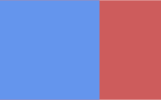

In [32]:
using Luxor

φ = (1 + sqrt(5)) / 2 # we'll soon see how to calculate φ
unit = 100 # our drawing unit in pts

Drawing(unit*φ, unit, "goldenrect.svg") # create an image with golden ratio

# fill the whole image
sethue("indianred")
rect(Point(0, 0), unit*φ, unit, action=:fill)

# fill a square with length unit
sethue("cornflowerblue")
rect(Point(0, 0), unit, unit, action=:fill)

finish()
preview()

Solving the equation for the golden ratio, finding a *closed form* for $\varphi$, we will refine the left hand side of the equation, using this trick:
$\varphi$ is defined as $\frac{a}{b}$, so $\frac{b}{a} = \frac{1}{\varphi}$:

$$
\frac{a+b}{a} = \frac{a}{a} + \frac{b}{a} = 1 + \frac{b}{a} = 1 + \frac{1}{\varphi}.
$$

Therfore,
$$
1 + \frac{1}{\varphi} = \varphi.
$$
Multiplying by $\varphi$ gives
$$
\varphi + 1 = \varphi^2,
$$
which can be rearranged to
$$
\varphi^2 - \varphi -1 = 0.
$$

Now we can apply the *quadratic formula*, which yields the two solutions

$$
\varphi_1 = \frac{1 + \sqrt 5}{2}, \quad \varphi_2 = \frac{1 - \sqrt 5}{2}.
$$

Because $\varphi$ is a ratio between positive quantities, $\varphi$ is necessarily the positive root

$$
\varphi = \frac{1 + \sqrt 5}{2}.
$$

Knowing the value of $\varphi$, we can now check if the ratio of consecutive Fibonacci numbers actually converges to $\varphi$:

In [33]:
φ = (1 + sqrt(5)) / 2

for n in range(25, 1; step=-1)
    @show n
    @assert fibMemo(n+1)/fibMemo(n) ≈ φ
end

n = 25
n = 24
n = 23
n = 22
n = 21
n = 20
n = 19


LoadError: AssertionError: fibMemo(n + 1) / fibMemo(n) ≈ φ

For all $n \geq 20$ the ratio of consecutive Fibonacci numbers is approximately equal to $\varphi$:
$$
\forall n \in \mathbb{N} \mid n \geq 20: \frac{F_{n+1}}{F_n} \approx \varphi.
$$

Finally, we will plot the *golden spiral*, using julia's `Plots` library.\
The *golden spiral* is a logarithmic spiral whose growth factor is $\varphi$, which means that it gets wider (or further away from its origin) by a factor of $\varphi$ for every quarter-turn.
A golden spiral with initial radius 1 has the following polar equation:

$$r = \varphi^{\theta \frac{2}{\pi}}.$$

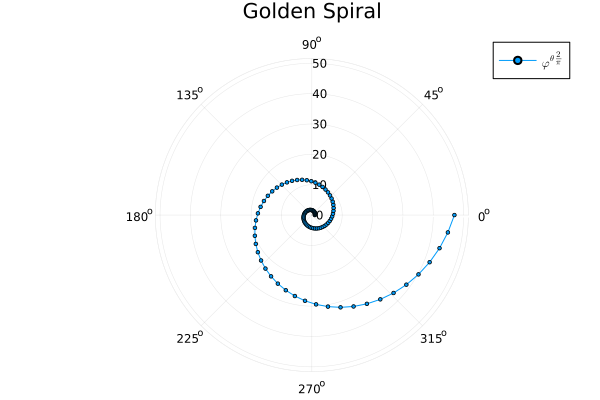

In [34]:
using Plots
using LaTeXStrings

θ = range(0, stop = 4π, length = 100)
r = φ .^ (2θ/π)
plot(θ, r, proj = :polar, m = 2, title="Golden Spiral", label=L"\varphi^{\theta \frac{2}{\pi}}")

### Fibonacci Spiral
The goal of this subsection is to create a *Fibonacci spiral* and to show visually that the *Fibonacci spiral* is an approximation of the *golden spiral*.

A first approach would be to simply plot the first Fibonacci terms on a polar plot, like we did before:

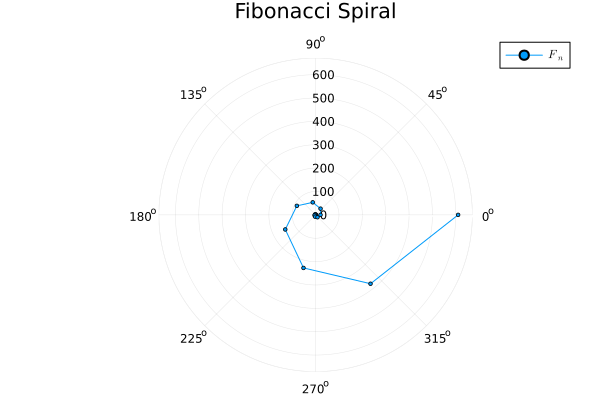

In [35]:
θ = range(0, stop = 4π, length = 15)
r = fib.(1:15)
plot(θ, r, proj = :polar, m = 2, title="Fibonacci Spiral", label=L"F_n")

Well, that looks almost like a spiral.
Although $F_n$ is a continuous function, it is only defined for $n \in \mathbb{N}$.
So we just don't have enough points in the range from 0 to $4\pi$ to smoothen the curve for the plot (for the *golden spiral* we've used 100 points).
Obviously, we need another approach.

For that, we first create a *Fibonacci tiling* by adding squares with side length $F_n$ counterclockwise to an empty plane.
Then, we superimpose a *Finonacci spiral* by adding a circular arc to every tile with a radius equal to the side length of the tile, changing the angle of the arc counterclockwise by 90 degrees for every next tile.

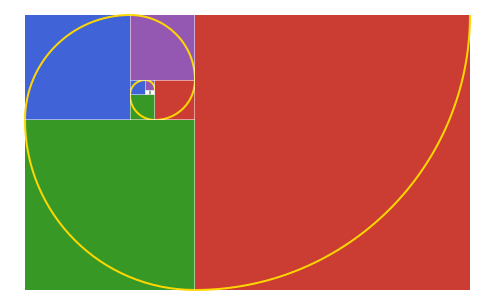

In [1]:
# Due to namespace conflicts with `Plots`, this cell will not run properly
# if `Plots` is loaded at the same time.
# To get proper results, restart the jupyter kernel and directly run this cell.

using Luxor

# our naive recursive version for fibonacci numbers
fib(n) = n < 2 ? n : fib(n-1) + fib(n-2)

# draw a single tile
function drawtile(n, c)
    fn = fib(n)
    setline(1)
    setcolor("white")
    rect(Point(0, 0), fn*u, fn*u, action=:stroke)
    setcolor(c)
    rect(Point(0, 0), fn*u, fn*u, action=:fill) # add color to tiles
    setcolor("gold")
    setline(2)
    a = n % 4
    if a == 0
        arc(Point(fn*u, fn*u), fn*u, -π, -π/2, action=:stroke) # blue
    elseif a == 1
        arc(Point(fn*u, 0), fn*u, -3π/2, -π, action=:stroke) # green
    elseif a == 2
        arc(Point(0, 0), fn*u, 0, π/2, action=:stroke) # red
    else
        arc(Point(0, fn*u), fn*u, -π/2, 0, action=:stroke) # purple
    end
end

# shift every new tile to its correct position
function shift(n)
    t = n % 4
    if t == 0
        translate(Point(-fib(n)*u, 0)) # left
    elseif t == 1
        translate(Point(0, fib(n-1)*u)) # down
    elseif t == 2
        translate(Point(fib(n-1)*u, -fib(n-2)*u)) # right
    else
        translate(Point(-fib(n-2)*u, -fib(n)*u)) # up
    end
end

# draw tiles recursively for n > 3
function drawtiles(n)
    if n > 3
        drawtiles(n-1)
        c = (colors[mod1(n, end)])
        shift(n)
        drawtile(n, c)
    end
end

# draw all tiles
function fibonacciTiling(n)
    setline(1)
    setcolor("gray")
    rect(Point(0,0), u, u, action=:stroke) # unitsquare for n = 1
    translate(Point(-u, 0))
    rect(Point(0,0), u, u, action=:stroke) # unitsquare for n = 2
    translate(Point(0, -2u))
    drawtile(3, Luxor.julia_purple) # n = 3
    drawtiles(n) # n > 3
end

# create and save drawing
Drawing(500, 300, "fibonacci-tiling.svg")
    u = 5
    translate(Point(150, 90)) # set start position for n = 1
    colors = (Luxor.julia_green, Luxor.julia_red, Luxor.julia_purple, Luxor.julia_blue)
    fibonacciTiling(10)
    finish()
preview()

### Binet's Formula
We've already showed that Kepler's conjecture is valid.
Of course, that's not a proof in a mathematical sense.

The proof can be given with *Binet's formula*, named after French mathematician Jacques Binet, who found a *closed-form* expression for $F_n$:

$$
F_n = \frac{\varphi^n - \psi^n}{\varphi - \psi} = \frac{\varphi^n - \psi^n}{\sqrt{5}},
$$
where $\varphi$ is the *golden ratio* and $\psi$ its conjugate:

$$
\psi = \frac{1 - \sqrt 5}{2} = 1 - \varphi = -\frac{1}{\varphi}.
$$

Since $\psi = -\varphi^{-1}$, this formula can also be written as

$$
F_n = \frac{\varphi^n - (-\varphi)^{-n}}{\sqrt{5}}.
$$

Since $|\frac{\psi^n}{\sqrt5}| < \frac{1}{2}$ for all $n \geq 0$, the value of $F_n$ is the closest integer to $\frac{\varphi^n}{\sqrt5}$.\
Therefore, we can compute $F_n$ by *rounding*:

$$
F_n = \lfloor \frac{\varphi^n}{\sqrt{5}} \rceil, \quad n \geq 0,
$$
leading to our final implementation of $F_n$:

In [2]:
using BenchmarkTools

φ = (1 + sqrt(5)) / 2
fibClosed(n::Integer)::BigInt = round(BigInt, (φ^n / sqrt(5)))
@btime fibClosed(40)

  150.456 ns (4 allocations: 72 bytes)


102334155

Now we have a fast alternative to our first naive recursive solution.
Unfortunately, it turns out that this implementation is quite limited for practical use:

In [3]:
for n in 65:75
    @show n
    @assert fibClosed(n-2) + fibClosed(n-1) == fibClosed(n)
end

n = 65
n = 66
n = 67
n = 68
n = 69
n = 70
n = 71


LoadError: AssertionError: fibClosed(n - 2) + fibClosed(n - 1) == fibClosed(n)

For $n \geq 71$ the function doesn't return the correct result.\
This is due to the internal representation of floating-point numbers of type `Float64` (produced by taking the square-root of 5 in the algorithm).
According to the *IEEE 754* standard, real numbers $\in \mathbb{R}$ are represented with 15 to 17 significant decimal digits.


In [5]:
ndigits(fibClosed(71))

15

Since $F_{71}$ has 15 digits, we conclude that exponentation and taking roots work precisely within this limit, but not for larger numbers.

We could have liftet that limit up to $F_{359}$ by using `BigFloat`, but we would get noway near to $F_{10,000}$, which was handeled by our iterative version with ease.